## Project #1: Bigmart Sale Prediction

<a id = "#initialization"></a>
<h2>Initializing Packages and Importing Data</h2>

In [1]:
from scipy.stats import mode
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import warnings  # Ignores any warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

<a id = "#viewdata"></a>
<h2>Taking a peak at our data</h2>

In [2]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
Item_Identifier              5681 non-null object
Item_Weight                  4705 non-null float64
Item_Fat_Content             5681 non-null object
Item_Visibility              5681 non-null float64
Item_Type                    5681 non-null object
Item_MRP                     5681 non-null float64
Outlet_Identifier            5681 non-null object
Outlet_Establishment_Year    5681 non-null int64
Outlet_Size                  4075 non-null object
Outlet_Location_Type         5681 non-null object
Outlet_Type                  5681 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [6]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [7]:
# Check for duplicates
idsUnique = len(set(train.Item_Identifier))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " +
      str(idsTotal) + " total entries")

There are 6964 duplicate IDs for 8523 total entries


<h2>1. Exploratory Data Analysis (EDA)</h2>
<h3>1.1. Univariate Distribution</h3>
<h4>1.1.1.  Distribution of the target variable : Item_Outlet_Sales</h4>

Text(0.5,1,'Item_Outlet_Sales Distribution')

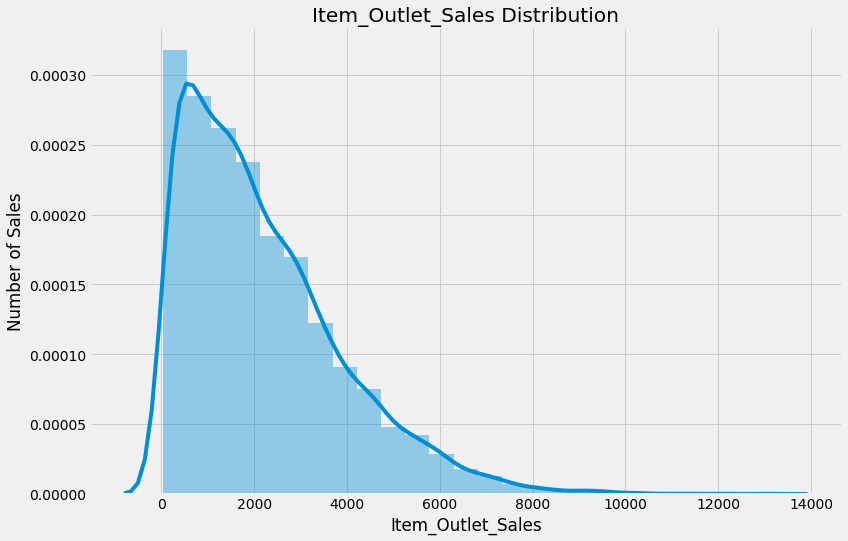

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.distplot(train.Item_Outlet_Sales, bins=25)
plt.ticklabel_format(style='plain', axis='x', scilimits=(0, 1))
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Number of Sales")
plt.title("Item_Outlet_Sales Distribution")

In [9]:
print ("Skew is:", train.Item_Outlet_Sales.skew())
print("Kurtosis: %f" % train.Item_Outlet_Sales.kurt())

('Skew is:', 1.1775306028542798)
Kurtosis: 1.615877


<h4>1.1.2. Numerical Variables</h4>


In [10]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
dtype: object

In [11]:
numeric_features.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


In [12]:
corr = numeric_features.corr()

print (corr['Item_Outlet_Sales'].sort_values(ascending=False))

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64


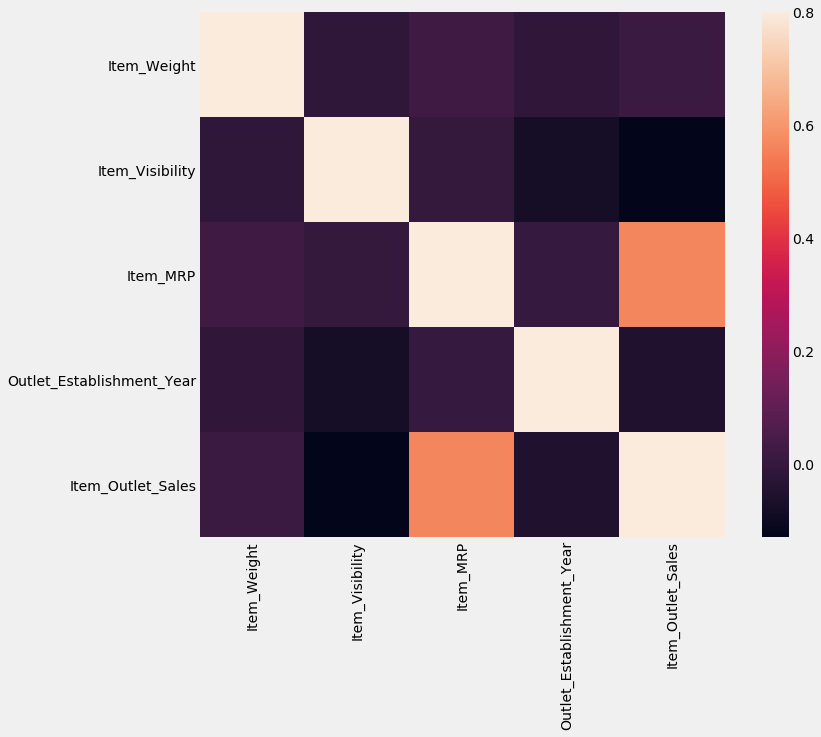

In [13]:
# correlation matrix
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True)

<h4>1.1.3. Categorical Variables</h4>
<h5>1.1.3.1. Distribution of the Item_Fat_Content</h5>

In [14]:
train.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

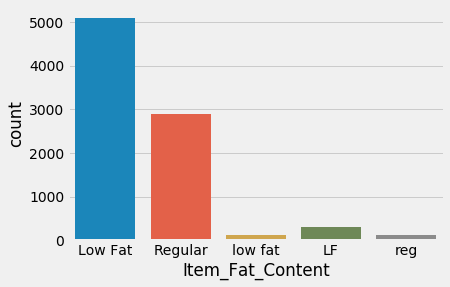

In [15]:
sns.countplot(train.Item_Fat_Content)

<h5>1.1.3.2. Distribution of the Item_Type</h5>

In [16]:
train.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

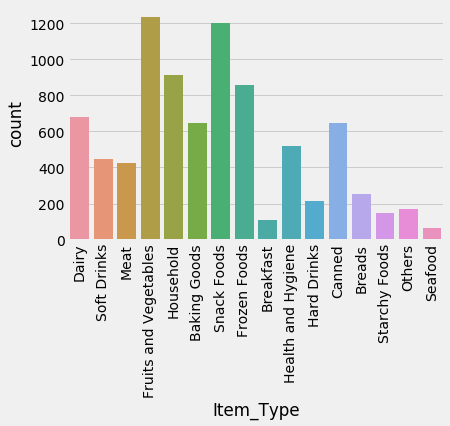

In [17]:
sns.countplot(train.Item_Type)
plt.xticks(rotation=90)

<h5>1.1.3.3. Distribution of the Outlet_Size</h5>

In [18]:
train.Outlet_Size.value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

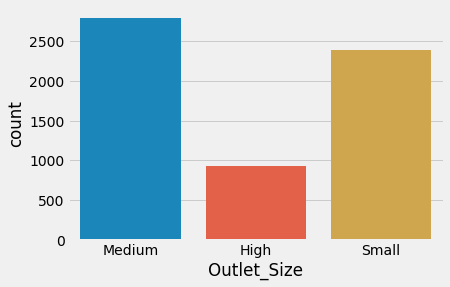

In [19]:
sns.countplot(train.Outlet_Size)

<h5>1.1.3.4. Distribution of the Outlet_Location_Type</h5>

In [20]:
train.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

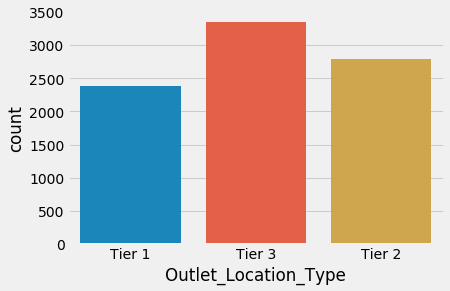

In [21]:
sns.countplot(train.Outlet_Location_Type)

<h5>1.1.3.5. Distribution of the Outlet_Type</h5>

In [22]:
train.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

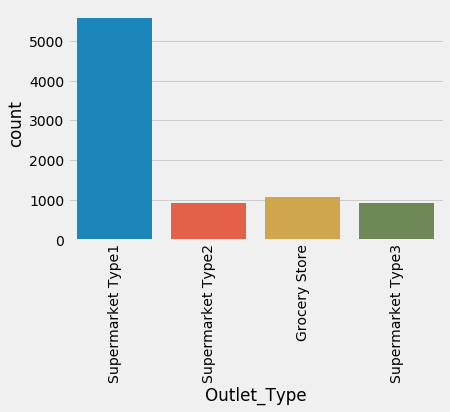

In [23]:
sns.countplot(train.Outlet_Type)
plt.xticks(rotation=90)

<h3>1.2. Bivariate Distribution</h3>
<h4>1.2.1. Numerical Variables</h4>
<h5>1.2.1.1. Item_Weight and Item_Outlet_Sales Analysis</h5>

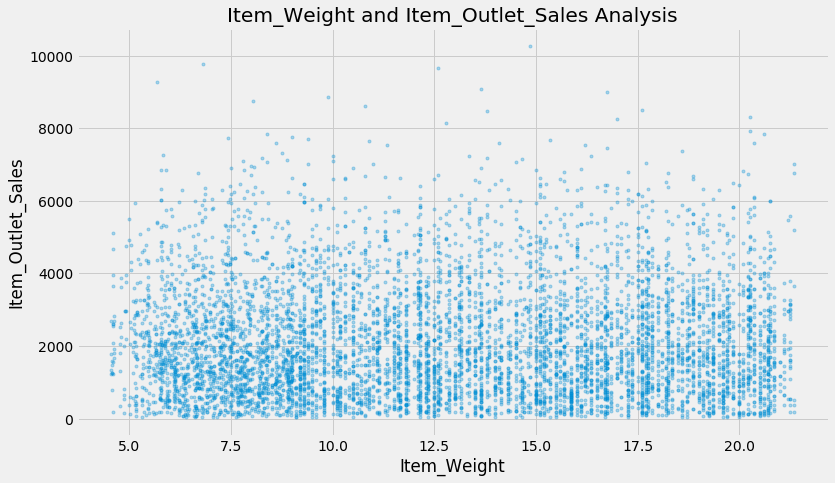

In [24]:
plt.figure(figsize=(12, 7))
plt.xlabel("Item_Weight")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Weight and Item_Outlet_Sales Analysis")
plt.plot(train.Item_Weight, train["Item_Outlet_Sales"], '.', alpha=0.3)

<h5>1.2.1.2. Item_Visibility and Item_Outlet_Sales Analysis</h5>

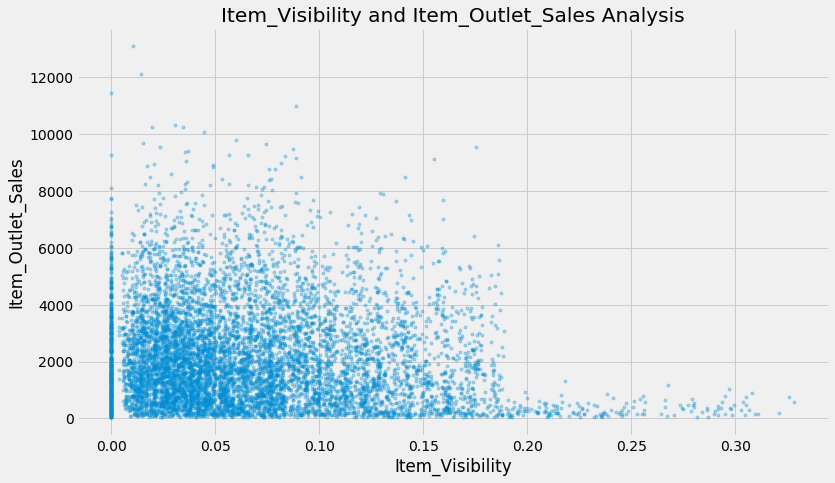

In [25]:
plt.figure(figsize=(12, 7))
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Visibility and Item_Outlet_Sales Analysis")
plt.plot(train.Item_Visibility, train["Item_Outlet_Sales"], '.', alpha=0.3)

<h5>1.2.1.3. Item_MRP and Item_Outlet_Sales Analysis</h5>

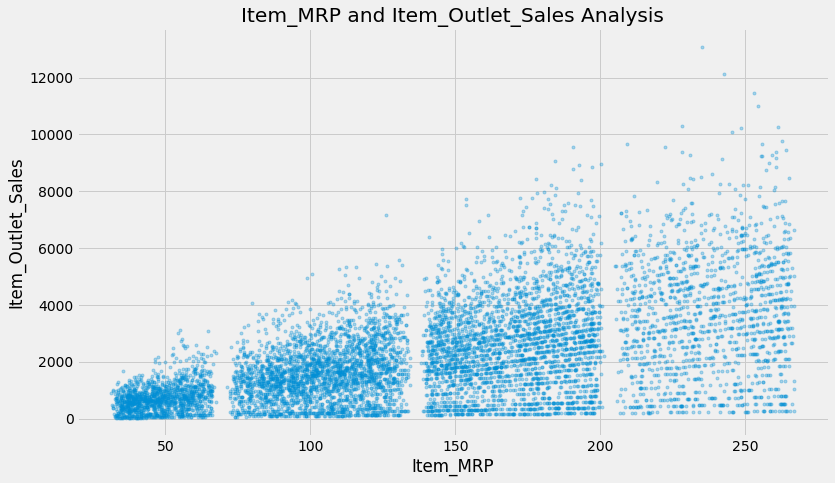

In [26]:
plt.figure(figsize=(12, 7))
plt.xlabel("Item_MRP")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_MRP and Item_Outlet_Sales Analysis")
plt.plot(train.Item_MRP, train["Item_Outlet_Sales"], '.', alpha=0.3)

<h5>1.2.1.4. Outlet_Establishment_Year and Item_Outlet_Sales Analysis</h5>

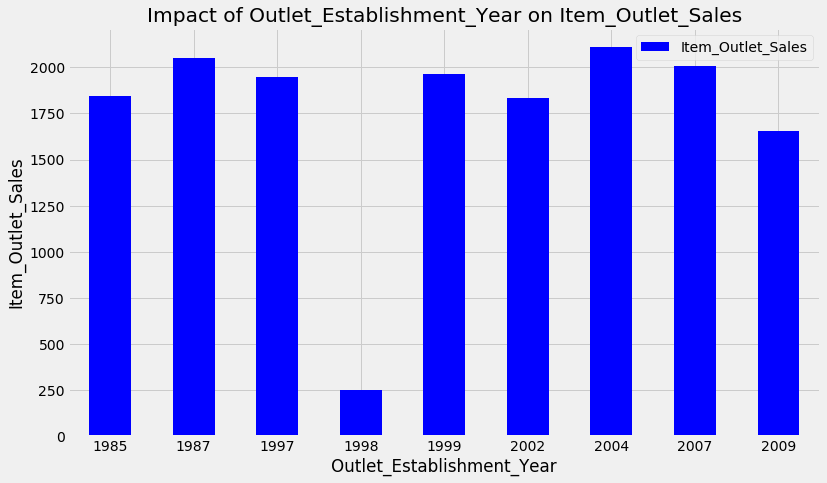

In [27]:
Outlet_Establishment_Year_pivot = \
    train.pivot_table(index='Outlet_Establishment_Year',
                      values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Establishment_Year_pivot.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Outlet_Establishment_Year")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Establishment_Year on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

<h4>1.2.2. Categorial Variables</h4>

In [28]:
numeric_features = train.select_dtypes(include=[np.object])
numeric_features.dtypes

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

<h5>1.2.2.1. Impact of Item_Identifier on Item_Outlet_Sales</h5>

In [29]:
'''
plt.figure(figsize=(12, 7))
plt.xlabel("Item_Identifier")
plt.ylabel("SQRT Item_Outlet_Sales")
plt.title("Item_Identifier  and Item_Outlet_Sales Analysis")
plt.plot(train.Item_Identifier, train["Item_Outlet_Sales"], '.', alpha=0.3)
'''

'\nplt.figure(figsize=(12, 7))\nplt.xlabel("Item_Identifier")\nplt.ylabel("SQRT Item_Outlet_Sales")\nplt.title("Item_Identifier  and Item_Outlet_Sales Analysis")\nplt.plot(train.Item_Identifier, train["Item_Outlet_Sales"], \'.\', alpha=0.3)\n'

<h5>1.2.2.2. Impact of Item_Fat_Content on Item_Outlet_Sales</h5>

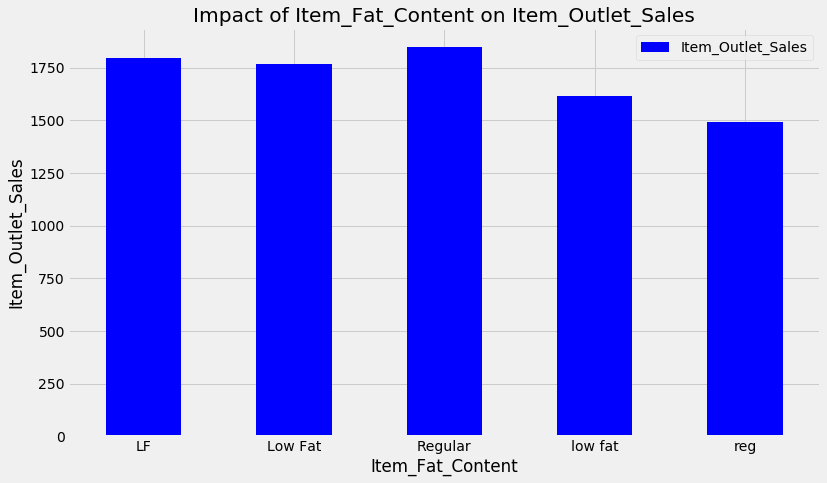

In [30]:
Item_Fat_Content_pivot = \
    train.pivot_table(index='Item_Fat_Content',
                      values="Item_Outlet_Sales", aggfunc=np.median)

Item_Fat_Content_pivot.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Item_Fat_Content")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Item_Fat_Content on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

<h5>1.2.2.3. Impact of Outlet_Identifier on Item_Outlet_Sales</h5>

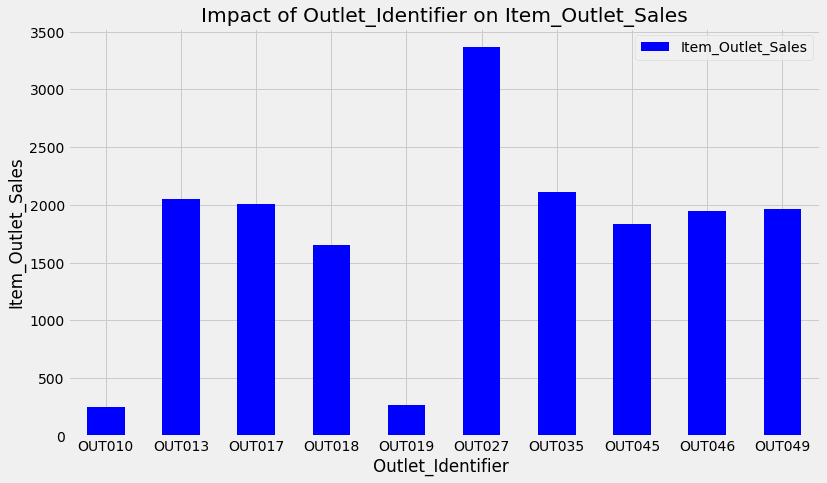

In [31]:
Outlet_Identifier_pivot = \
    train.pivot_table(index='Outlet_Identifier',
                      values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Identifier_pivot.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Outlet_Identifier ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Identifier on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

In [32]:
train.pivot_table(values='Outlet_Type',
                  columns='Outlet_Identifier', aggfunc=lambda x: x.mode())

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type1,Supermarket Type2,Grocery Store,Supermarket Type3,Supermarket Type1,Supermarket Type1,Supermarket Type1,Supermarket Type1


In [33]:
train.pivot_table(values='Outlet_Type', columns='Outlet_Size',
                  aggfunc=lambda x: x.mode())

Outlet_Size,High,Medium,Small
Outlet_Type,Supermarket Type1,Supermarket Type3,Supermarket Type1


<h5>1.2.2.4. Impact of Outlet_Size on Item_Outlet_Sales</h5>

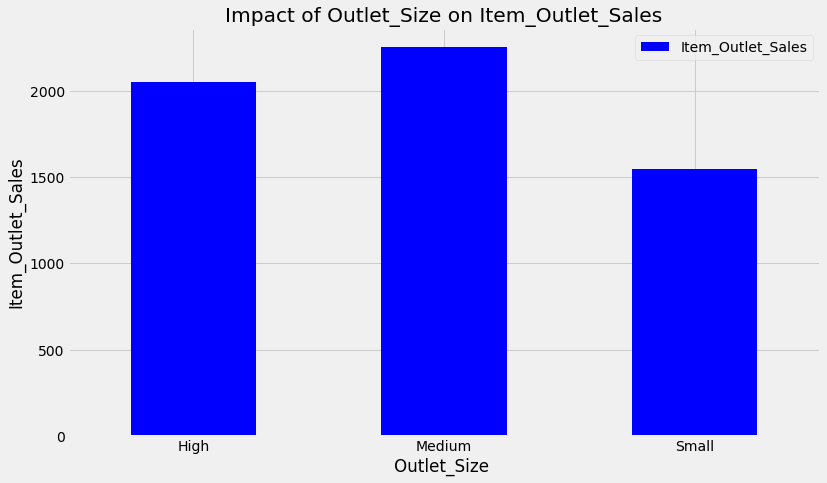

In [34]:
Outlet_Size_pivot = \
    train.pivot_table(index='Outlet_Size',
                      values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Size_pivot.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Outlet_Size ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Size on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

<h5>1.2.2.5. Impact of Outlet_Location_Type on Item_Outlet_Sales</h5>

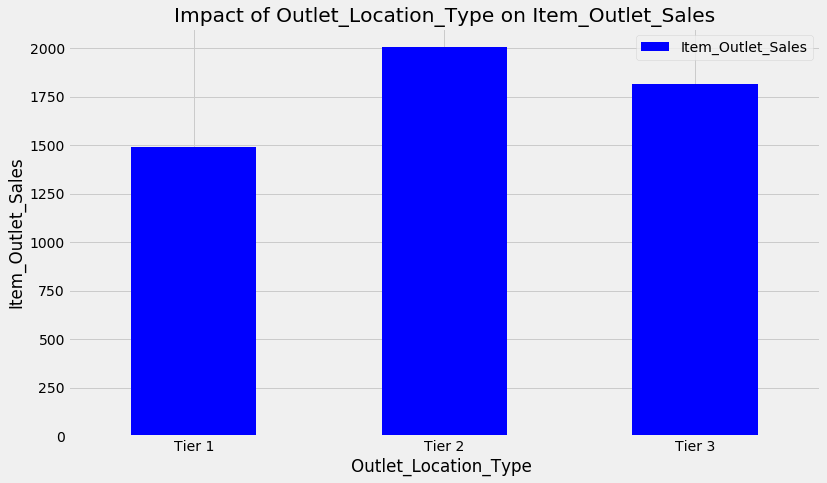

In [35]:
Outlet_Location_Type_pivot = \
    train.pivot_table(index='Outlet_Location_Type',
                      values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Location_Type_pivot.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Outlet_Location_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Location_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

In [36]:
train.pivot_table(values='Outlet_Location_Type',
                  columns='Outlet_Type', aggfunc=lambda x: x.mode())

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Location_Type,Tier 3,Tier 2,Tier 3,Tier 3


<h5>1.2.2.6. Impact of Outlet_Type on Item_Outlet_Sales</h5>

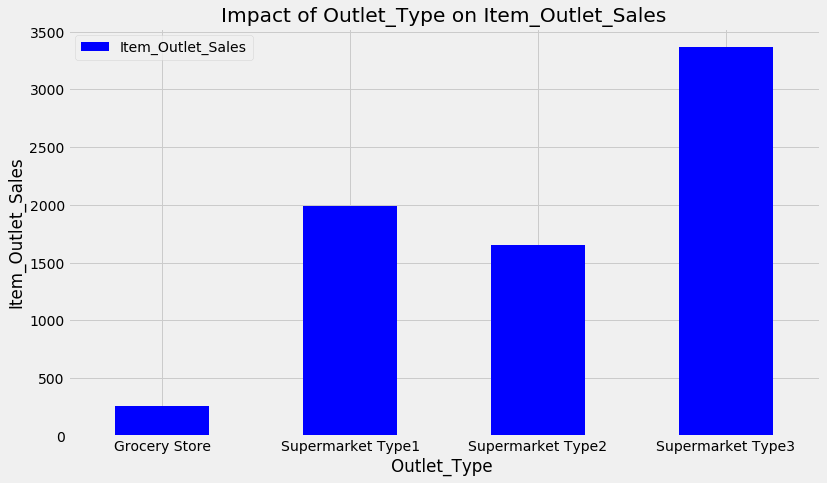

In [37]:
Outlet_Type_pivot = \
    train.pivot_table(index='Outlet_Type',
                      values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Type_pivot.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Outlet_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

<h5>1.2.2.7. Impact of Item_Type on Item_Outlet_Sales</h5>

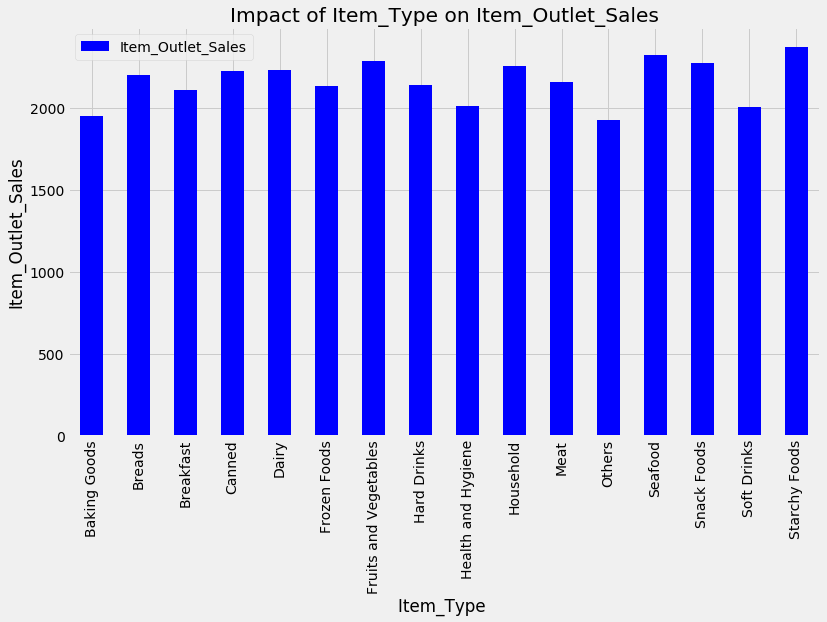

In [38]:
pivoTable = \
    train.pivot_table(index='Item_Type',
                      values="Item_Outlet_Sales", aggfunc=np.mean)

pivoTable.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Item_Type ")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Item_Type on Item_Outlet_Sales")
plt.xticks(rotation=90)
plt.show()

<h5>1.2.2.8. Impact of Item_Type vs Item_Visibility</h5>

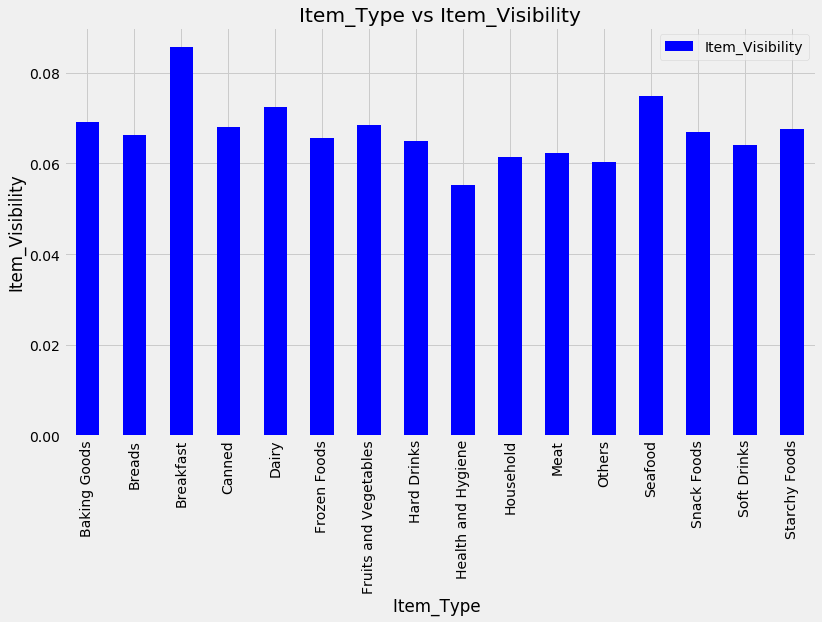

In [39]:
pivoTable = \
    train.pivot_table(index='Item_Type',
                      values="Item_Visibility", aggfunc=np.mean)

pivoTable.plot(kind='bar', color='blue', figsize=(12, 7))
plt.xlabel("Item_Type ")
plt.ylabel("Item_Visibility")
plt.title("Item_Type vs Item_Visibility")
plt.xticks(rotation=90)
plt.show()

<h2>2. Data Pre-Processing</h2>
<h3> 2.1. Looking for missing values</h3>

In [40]:
# Join Train and Test Dataset
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train, test], ignore_index=True)
data.to_csv("data.csv", index=False)
print(train.shape, test.shape, data.shape)

((8523, 13), (5681, 12), (14204, 13))


<h3> 2.2. Imputing Missing Values </h3>

In [41]:
# aggfunc is mean by default! Ignores NA by default
item_avg_weight = data.pivot_table(
    values='Item_Weight', index='Item_Identifier')
print(item_avg_weight)

                 Item_Weight
Item_Identifier             
DRA12                 11.600
DRA24                 19.350
DRA59                  8.270
DRB01                  7.390
DRB13                  6.115
DRB24                  8.785
DRB25                 12.300
DRB48                 16.750
DRC01                  5.920
DRC12                 17.850
DRC13                  8.260
DRC24                 17.850
DRC25                  5.730
DRC27                 13.800
DRC36                 13.000
DRC49                  8.670
DRD01                 12.100
DRD12                  6.960
DRD13                 15.000
DRD15                 10.600
DRD24                 13.850
DRD25                  6.135
DRD27                 18.750
DRD37                  9.800
DRD49                  9.895
DRD60                 15.700
DRE01                 10.100
DRE03                 19.600
DRE12                  4.590
DRE13                  6.280
...                      ...
NCX05                 15.200
NCX06         

In [42]:
def impute_weight(cols):
    Weight = cols[0]
    Identifier = cols[1]

    if pd.isnull(Weight):
        return item_avg_weight['Item_Weight'][item_avg_weight.index == Identifier]
    else:
        return Weight

In [43]:
print ('Orignal #missing: %d' % sum(data['Item_Weight'].isnull()))
data['Item_Weight'] = data[['Item_Weight', 'Item_Identifier']].apply(
    impute_weight, axis=1).astype(float)
print ('Final #missing: %d' % sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


<h3> 2.3. Imputing Outlet_size with the mode</h3>


In [44]:
# Determing the mode for each
outlet_size_mode = data.pivot_table(
    values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode())
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [45]:
def impute_size_mode(cols):
    Size = cols[0]
    Type = cols[1]
    if pd.isnull(Size):
        return outlet_size_mode.loc['Outlet_Size'][outlet_size_mode.columns == Type][0]
    else:
        return Size


print ('Orignal #missing: %d' % sum(data['Outlet_Size'].isnull()))
data['Outlet_Size'] = data[['Outlet_Size', 'Outlet_Type']].apply(
    impute_size_mode, axis=1)
print ('Final #missing: %d' % sum(data['Outlet_Size'].isnull()))

Orignal #missing: 4016
Final #missing: 0


<h2>3. Feature Engineering</h2>

<h4> 3.1. Should we combine Outlet_Type?</h4>


In [46]:
# Creates pivot table with Outlet_Type and the mean of Item_Outlet_Sales. Agg function is by default mean()
data.pivot_table(values='Item_Outlet_Sales', columns='Outlet_Type')

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Item_Outlet_Sales,339.8285,2316.181148,1995.498739,3694.038558


<h4> 3.2. Item_Visibility minimum value 0</h4>

In [47]:
# Get all Item_Visibility mean values for respective Item_Identifier
visibility_item_avg = data.pivot_table(
    values='Item_Visibility', index='Item_Identifier')

In [48]:
def impute_visibility_mean(cols):
    visibility = cols[0]
    item = cols[1]
    if visibility == 0:
        return visibility_item_avg['Item_Visibility'][visibility_item_avg.index == item]
    else:
        return visibility


print ('Original #zeros: %d' % sum(data['Item_Visibility'] == 0))
data['Item_Visibility'] = data[['Item_Visibility', 'Item_Identifier']].apply(
    impute_visibility_mean, axis=1).astype(float)
print ('Final #zeros: %d' % sum(data['Item_Visibility'] == 0))

Original #zeros: 879
Final #zeros: 0


<h4> 3.3. Determine the years of operation of a store</h4>


In [49]:
# Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

<h4> 3.4. Create a broad category of Type of Item</h4>

In [50]:
# Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
# Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD': 'Food',
                                                             'NC': 'Non-Consumable',
                                                             'DR': 'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

<h4> 3.5. Modify categories of Item_Fat_Content</h4>


In [51]:
# Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                             'reg': 'Regular',
                                                             'low fat': 'Low Fat'})

print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [52]:
# Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined'] ==
         "Non-Consumable", 'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

<h2>4. Feature Transformations</h2>

<h4> 4.1. Creating variable Item_Visibility_MeanRatio</h4>

In [53]:
def func(x): return x['Item_Visibility'] / \
    visibility_item_avg['Item_Visibility'][visibility_item_avg.index ==
                                           x['Item_Identifier']][0]


data['Item_Visibility_MeanRatio'] = data.apply(func, axis=1).astype(float)
data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64

<h4> 4.2. Numerical and Categorical Variables – Dummy variables</h4>

In [54]:
le = LabelEncoder()

# New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content', 'Outlet_Location_Type',
           'Outlet_Size', 'Item_Type_Combined', 'Outlet_Type', 'Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [55]:
# Dummy Variables:
data = pd.get_dummies(data, columns=['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type',
                                     'Item_Type_Combined', 'Outlet'])

data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Outlet_Years                   int64
Item_Visibility_MeanRatio    float64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

<h4> 4.3. Exporting Data</h4>


In [56]:
# Drop the columns which have been converted to different types:
data.drop(['Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

# Divide into test and train:
train = data.loc[data['source'] == "train"]
test = data.loc[data['source'] == "test"]

# Drop unnecessary columns:
test.drop(['Item_Outlet_Sales', 'source'], axis=1, inplace=True)
train.drop(['source'], axis=1, inplace=True)

# Export files as modified versions:
train.to_csv("train_modified.csv", index=False)
test.to_csv("test_modified.csv", index=False)

<h2>5. Model, predict and solve the problem</h2>

In [57]:
train_df = pd.read_csv('train_modified.csv')
test_df = pd.read_csv('test_modified.csv')

In [58]:
# Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier', 'Outlet_Identifier']


def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    # Perform cross-validation:
    cv_score = cross_val_score(
        alg, dtrain[predictors], (dtrain[target]), cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))

    # Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(
        (dtrain[target]).values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" %
          (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    # Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])

    # Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

<h4 style = "text-align:justify;font-family:Verdana;font-size:14px">
Linear Regression Model
</h4>


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.51 | Min - 1074 | Max - 1210


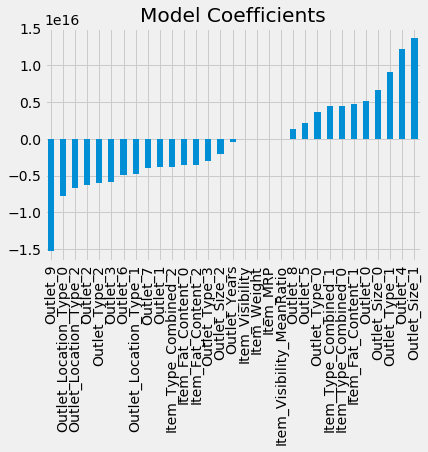

In [59]:
LR = LinearRegression(normalize=True)

predictors = train_df.columns.drop(
    ['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
modelfit(LR, train_df, test_df, predictors, target, IDcol, 'LR.csv')

coef1 = pd.Series(LR.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

<h4 style = "text-align:justify;font-family:Verdana;font-size:14px">
Ridge Regression Model
</h4>


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


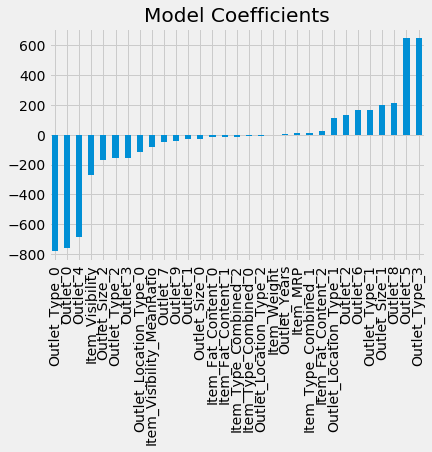

In [60]:
RR = Ridge(alpha=0.05, normalize=True)
modelfit(RR, train_df, test_df, predictors, target, IDcol, 'RR.csv')

coef2 = pd.Series(RR.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

<h4 style = "text-align:justify;font-family:Verdana;font-size:14px">
Decision Tree Model
</h4>


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


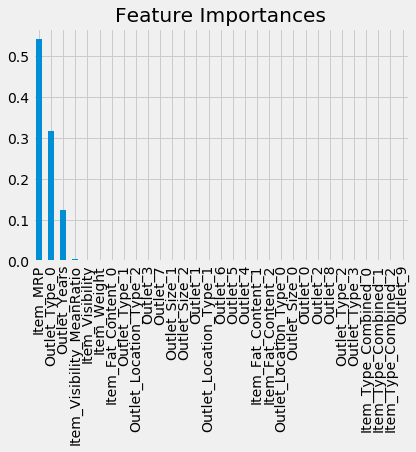

In [61]:
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(DT, train_df, test_df, predictors, target, IDcol, 'DT.csv')

coef3 = pd.Series(DT.feature_importances_,
                  predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

<h4 style = "text-align:justify;font-family:Verdana;font-size:14px">
Random Forest Model
</h4>


Model Report
RMSE : 1069
CV Score : Mean - 1097 | Std - 43.41 | Min - 1028 | Max - 1180


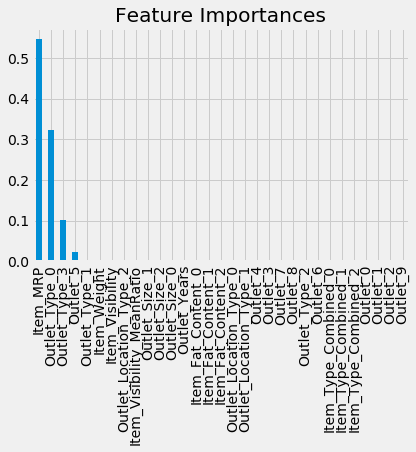

In [62]:
RF = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(RF, train_df, test_df, predictors, target, IDcol, 'RF.csv')

coef4 = pd.Series(RF.feature_importances_,
                  predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

<h4 style = "text-align:justify;font-family:Verdana;font-size:14px">
xgboost
</h4>

In [63]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_df[predictors], train_df[target], early_stopping_rounds=5,
             eval_set=[(test_df[predictors], test_df[target])], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [64]:
# Predict training set:
train_df_predictions = my_model.predict(train_df[predictors])

# make predictions
predictions = my_model.predict(test_df[predictors])

In [65]:
print("Mean Absolute Error : " +
      str(mean_absolute_error(predictions, test_df[target])))
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(
    (train_df[target]).values, train_df_predictions)))

Mean Absolute Error : 129.90780382232205
RMSE : 1052


In [66]:
IDcol.append(target)
submission = pd.DataFrame({x: test_df[x] for x in IDcol})
submission.to_csv("XGboost.csv", index=False)